<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/energy_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy and emissions

This notebook aims to show the link (if not causal relationship) between **energy consumption** (or production) and **Greenhouse Gas** (GHG) emissions.

This notebook is coded in Python and relies on a few libraries (or packages), which we load below.


In [17]:
import pandas as pd                      # This library is for data wrangling
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px              # This is another library for plots 
import requests
import json
from zipfile import ZipFile
from io import BytesIO
import warnings                          # This is to remove warning to keep output clean
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown

## Emissions data: long-term perspective


We will resort to two datasets for emissions: one for a dynamic analysis on GHG and one for a cross-sectional study on carbon emissions only.  
As we will see, depending on the source, the results may substantially change.  
We obtain the first one from the website https://resourcewatch.org/data/explore/cli008-Greenhouse-Gas-Emissions-by-Country-and-Sector-Full-Longform.   
The data comes from the Climate Analysis Indicators Tools (CAIT) Climate Data Explorer.



In [18]:
url = 'https://wri-public-data.s3.amazonaws.com/resourcewatch/cli_008_greenhouse_gas_emissions_country_sector.zip'
filename = requests.get(url).content
zf = ZipFile( BytesIO(filename), 'r')
zf.getinfo('historical_emissions.zip')
zf = ZipFile(zf.open('historical_emissions.zip'))

data_ghg = pd.read_csv(zf.open('historical_emissions.csv'))
data_ghg

,Country,Data source,Sector,Gas,Unit,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,World,CAIT,Total including LUCF,All GHG,MtCO₂e,48939.71,47990.47,47413.95,46760.47,46647.29,46047.13,45427.61,44891.40,44758.58,43029.01,43003.97,42644.63,41831.65,40300.03,39437.14,37618.01,36727.84,35701.77,35607.73,34948.94,34929.19,35387.89,34068.91,33703.46,32977.47,32766.49,32670.32,32813.46,32645.91
1,World,CAIT,Total excluding LUCF,All GHG,MtCO₂e,47552.14,46770.42,46146.35,45974.01,45909.35,45658.86,44994.97,44486.72,43268.37,41203.89,41571.04,41172.98,39826.52,38668.69,37527.82,36072.46,34874.73,34363.55,33936.77,33129.09,32918.04,32706.56,32357.54,31788.31,31068.15,30857.21,30761.03,30904.18,30736.62
2,World,CAIT,Energy,All GHG,MtCO₂e,37224.95,36539.61,36080.14,36060.24,36053.93,35997.40,35390.08,34998.41,34064.92,32205.11,32624.44,32287.22,31158.63,30201.08,29169.44,27915.32,26782.94,26392.45,25987.41,25236.65,25085.99,24925.72,24544.78,24048.52,23464.22,23432.23,23345.54,23506.23,23363.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,Saint Vincent and the Grenadines,CAIT,Fugitive Emissions,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2706,Vanuatu,CAIT,Fugitive Emissions,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2707,Samoa,CAIT,Fugitive Emissions,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


All units are in equivalents of CO_2 metric tons, so we can remove the column. Same for the data source, which is not useful for us now - as well as for "Gas".  
We need to reshape the data to a 'long' format.

In [19]:
data_ghg = data_ghg.drop(labels = ['Unit', 'Data source', 'Gas'], axis=1)
data_ghg = pd.wide_to_long(data_ghg, 
                stubnames = [''], 
                i = ['Country', 'Sector'],
                j = 'Year').reset_index()
data_ghg = data_ghg.rename(columns = {"": "Emissions"})
data_ghg

,Country,Sector,Year,Emissions
0,World,Total including LUCF,2018,48939.71
1,World,Total including LUCF,2017,47990.47
2,World,Total including LUCF,2016,47413.95
...,...,...,...,...
78529,Samoa,Fugitive Emissions,1992,0.00
78530,Samoa,Fugitive Emissions,1991,0.00
78531,Samoa,Fugitive Emissions,1990,0.00


Let's see which are the sector categories.

In [20]:
data_ghg.Sector.unique() # List of sectors

array(['Total including LUCF', 'Total excluding LUCF', 'Energy',
       'Electricity/Heat', 'Transportation', 'Manufacturing/Construction',
       'Agriculture', 'Industrial Processes', 'Fugitive Emissions',
       'Building', 'Waste', 'Other Fuel Combustion',
       'Land-Use Change and Forestry', 'Bunker Fuels'], dtype=object)

That's a lot! Let's see the dynamic.

In [21]:
data_ghg_global_plot = data_ghg.query('Sector != "Total including LUCF"').query('Sector != "Total excluding LUCF"') # Remove some sectors
data_ghg_global_plot = data_ghg_global_plot.query('Country == "World"')
data_ghg_global_plot = data_ghg_global_plot.drop_duplicates(subset = ['Year', 'Sector'])
data_ghg_global_plot = data_ghg_global_plot.pivot(index = ['Year'], 
                                                  columns = 'Sector', 
                                                  values = "Emissions").reset_index()
data_ghg_global_plot

Sector,Year,Agriculture,Building,Bunker Fuels,Electricity/Heat,Energy,Fugitive Emissions,Industrial Processes,Land-Use Change and Forestry,Manufacturing/Construction,Other Fuel Combustion,Transportation,Waste
0,1990,4997.83,2596.85,630.86,8596.17,23363.95,2253.38,1010.44,1909.29,3955.39,1353.12,4609.04,1364.40
1,1991,4988.46,2622.04,638.25,8735.04,23506.23,2261.86,1014.31,1909.29,3875.91,1362.83,4648.55,1395.18
2,1992,4966.82,2514.52,675.22,8894.60,23345.54,2165.36,1030.40,1909.29,3743.48,1274.10,4753.49,1418.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,2016,5737.28,2737.47,1225.10,14949.51,36080.14,2889.31,2768.08,1267.61,6188.61,1437.09,7878.14,1560.85
27,2017,5821.07,2796.01,1280.82,15167.36,36539.61,2879.97,2825.88,1220.05,6174.41,1443.42,8078.45,1583.86
28,2018,5817.65,2882.54,1311.60,15590.95,37224.95,2883.39,2902.68,1387.56,6158.32,1452.02,8257.73,1606.86


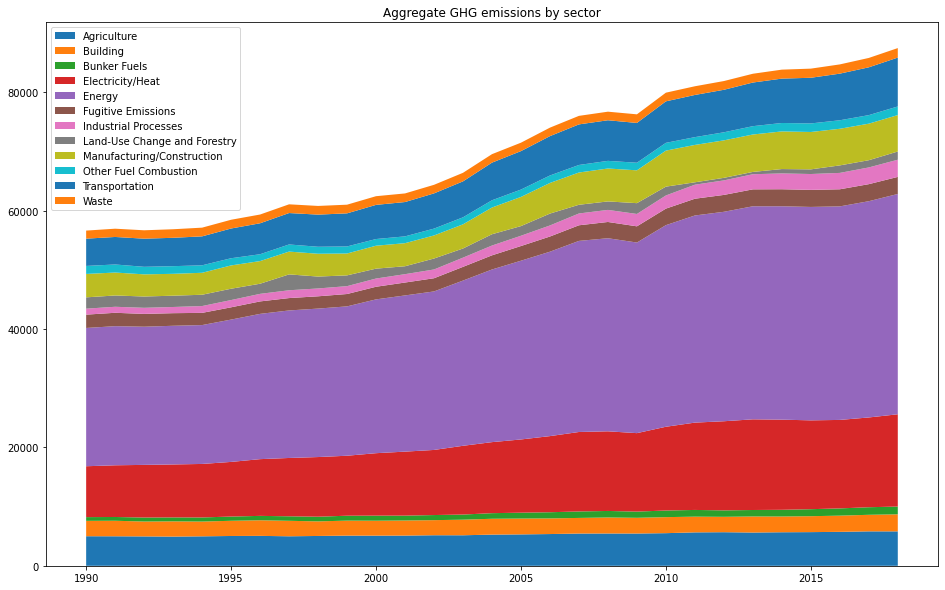

In [22]:
plt.stackplot(data_ghg_global_plot['Year'],
              data_ghg_global_plot.drop('Year', axis = 1).to_numpy().transpose(),
              labels = list(data_ghg_global_plot.drop('Year', axis = 1).columns))
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"]=(16, 10)
plt.title('Aggregate GHG emissions by sector')
plt.show()

##  Emissions: recent high frequency data
Our second source for emissions comes from Carbon Monitor: https://carbonmonitor.org. 
The website samples emissions at the daily frequency!*texte en italique*

In [23]:
url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'
data_carbon = pd.read_csv(url, skiprows = 0)
data_carbon['date'] = pd.to_datetime(data_carbon['date'],format='%d/%m/%Y') # Correct date format
# Below, we switch to capital letters for 1st character of column names
data_carbon = data_carbon.rename(columns={'country': 'Country', 
                                          'date': 'Date', 
                                          'sector': 'Sector', 
                                          'value': 'Value', 
                                          'timestamp': 'Timestamp'})
data_carbon

,Country,Date,Sector,Value,Timestamp
0,Brazil,2019-01-01,Power,0.108768,1546272000
1,China,2019-01-01,Power,14.251000,1546272000
2,EU27 & UK,2019-01-01,Power,1.676910,1546272000
...,...,...,...,...,...
81813,UK,2021-08-31,International Aviation,0.056121,1630339200
81814,US,2021-08-31,International Aviation,0.160910,1630339200
81815,WORLD,2021-08-31,International Aviation,1.071320,1630339200


Let's have a look at one country in particular.

In [24]:
data_fr

Sector,Date,Domestic Aviation,Ground Transport,Industry,International Aviation,Power,Residential
0,2019-01-01,0.003933,0.210608,0.060181,0.044197,0.049075,0.329052
1,2019-01-02,0.005495,0.246682,0.126566,0.046196,0.103208,0.358711
2,2019-01-03,0.005173,0.301693,0.147735,0.050451,0.120470,0.410727
...,...,...,...,...,...,...,...
971,2021-08-29,0.007647,0.261638,0.105726,0.049976,0.017607,0.121463
972,2021-08-30,0.006985,0.344803,0.203897,0.045768,0.033955,0.106594
973,2021-08-31,0.006985,0.350398,0.262435,0.045768,0.043704,0.099234


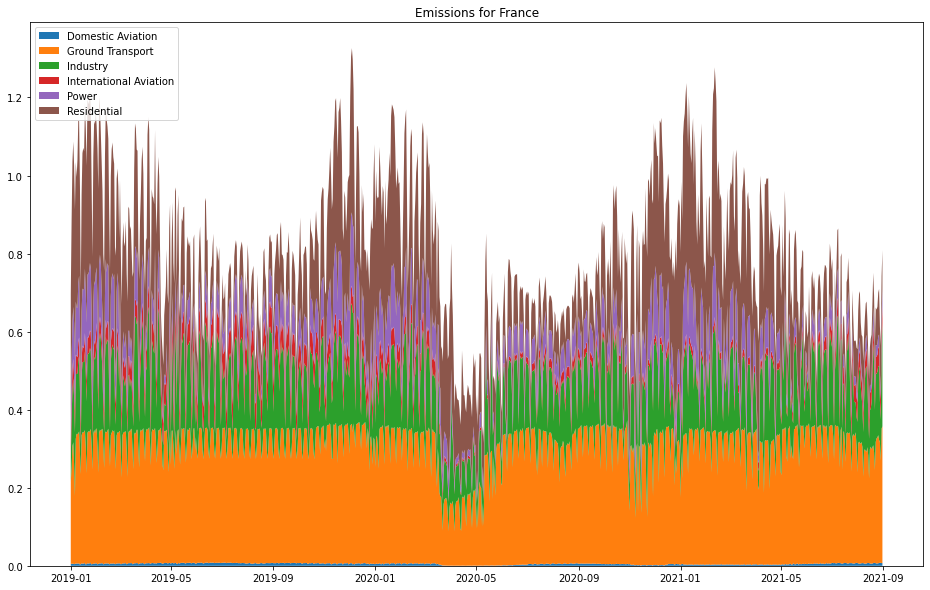

In [25]:
data_fr = data_carbon.query('Country == "France"')
data_fr = data_fr.drop_duplicates(subset = ['Date', 'Sector'])
data_fr = data_fr.pivot(index = 'Date', 
                        columns = 'Sector', 
                        values = "Value").reset_index()
plt.stackplot(data_fr['Date'],
              data_fr.drop('Date', axis = 1).to_numpy().transpose(),
              labels = list(data_fr.drop('Date', axis = 1).columns))
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"]=(16, 10)
plt.title('Emissions for France')
plt.show()

**NOTE**: the data starts in 2019 "only". We leave it aside for now....

## Energy data

For **energy** production and consumption, we use data compiled by **BP**. While it is undeniably a corporate source, it is widely considered as reliable, especially for non renewable energies. For renewables, the post https://www.resilience.org/stories/2017-08-02/how-bp-is-minimizing-renewable-energy-in-its-statistical-review/ contends that the company purposefully minimizes the numbers. For our study, this will not be a major issue.

In [26]:
url = 'https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/energy-economics/statistical-review/bp-stats-review-2021-consolidated-dataset-narrow-format.xlsx'
data_energy_sources = pd.read_excel(url) # Reads the online file 
data_energy_sources                      # Shows the result

,Country,Year,ISO3166_alpha3,ISO3166_numeric,Region,SubRegion,OPEC,EU,OECD,CIS,Var,Value
0,Algeria,1965,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
1,Algeria,1966,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
2,Algeria,1967,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
252913,Zimbabwe,2018,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.438812
252914,Zimbabwe,2019,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.645473
252915,Zimbabwe,2020,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.862927


We see that the suffixes tell the units in which the values are expressed. For instance, "ej" refers to **exajoule**, which is 10^18 joules while "pt" to **petajoule**, which is 10^15 joules. The joule is a classical unit used to quantify amounts of energy.  
For obvious **consistency** reasons, we need to put all joule type units at the same scale, which we choose to be the petajoule. Hence, we need to multiply the exajoule values by 1,000.

In [27]:
data_energy_sources = data_energy_sources[data_energy_sources['Var'].str.endswith('j')]
data_energy_sources['Scale'] = data_energy_sources['Var'].transform(lambda x: 1000 if x.endswith('ej') else 1) # Scale column  
data_energy_sources['Value'] = data_energy_sources['Value'] * data_energy_sources['Scale']            # Adjusted value
data_energy_sources = data_energy_sources.loc[:, ['Country', 'Year', 'Region', 'Var', 'Value']]       # Keeping 5 columns
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_ej'))   # Remove suffix
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_pj'))   # Remove suffix
data_energy_sources = data_energy_sources.rename(columns = {'Value' : 'Consumption'})                 # Change name of column
categories = ['wind',
              'solar',
              'renewables',
              'ren_power',
              'oilcons',
              'nuclear',
              'hydro',
              'gascons',
              'ethanol_cons',
              'coalcons',
              'biogeo',
              'biofuels_cons',
              'biodiesel_cons']
data_energy_sources = data_energy_sources[data_energy_sources['Var'].isin(categories)]                 # Reduce number of variables
data_energy_sources

,Country,Year,Region,Var,Consumption
10006,Algeria,1965,Africa,wind,0.000000
10007,Algeria,1966,Africa,wind,0.000000
10008,Algeria,1967,Africa,wind,0.000000
...,...,...,...,...,...
245380,US,2018,North America,biodiesel_cons,237.209821
245381,US,2019,North America,biodiesel_cons,225.887978
245382,US,2020,North America,biodiesel_cons,232.231787


## Visualizing trends

In order to plot macro trends, we must aggregate series

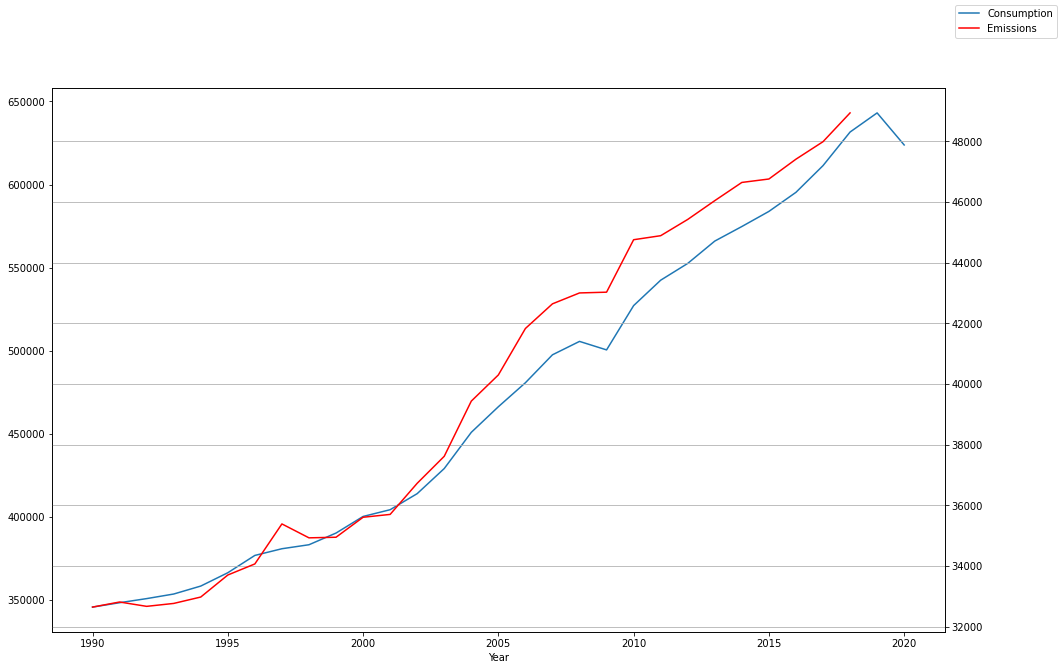

In [28]:
ax = data_energy_sources.query('Country == "Total World" & Year > 1989').pivot_table(values=['Consumption'],  # This creates the pivot table
                                       aggfunc='sum', 
                                       index=['Country','Year']).reset_index().plot(x = "Year", 
                                                                                    y = "Consumption", 
                                                                                    legend = False) 


ax2 = ax.twinx()
data_ghg.query('Country == "World" & Sector == "Total including LUCF"').plot(x = "Year", y = "Emissions", ax = ax2, legend = False, color = "r")
ax.figure.legend()
plt.grid()
plt.show()
plt.rcParams["figure.figsize"]=(10, 6)

The link between the two curves is astonishing (the emissions data stops a bit early).   
Let's have a look at the breakdown in terms of energy source.

In [29]:
data_energy_sectors = data_energy_sources.query('Country == "Total World"').drop_duplicates(subset = ['Year', 'Var'])
data_energy_sectors = data_energy_sectors.pivot(index = ['Year'], 
                                                                          columns = 'Var', 
                                                                          values = "Consumption").reset_index()
data_energy_sectors                                                               

Var,Year,biodiesel_cons,biofuels_cons,biogeo,coalcons,ethanol_cons,gascons,hydro,nuclear,oilcons,ren_power,renewables,solar,wind
0,1965,NaN,32.507508,179.852321,58104.641832,NaN,22693.676146,9231.979239,255.397242,64719.229929,179.852321,212.359829,0.000000,0.000000
1,1966,NaN,33.155433,198.060069,58766.737854,NaN,24727.660295,9838.170370,344.332903,69603.852100,198.060069,231.215502,0.000000,0.000000
2,1967,NaN,33.781369,199.865707,57818.915036,NaN,26546.541743,10057.426517,410.060140,74588.598448,199.865707,233.647076,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,2018,1388.504387,3702.122284,5656.292888,159260.311158,2313.617898,138164.262163,37370.361804,24127.270371,191328.179584,22177.356211,25879.478483,5162.195372,11358.867951
54,2019,1515.362928,3957.077447,5911.430639,157639.143841,2441.714520,140541.848501,37688.955419,24929.971958,191889.526763,24864.190436,28821.268024,6310.654018,12642.105779
55,2020,1527.845223,3761.025870,6217.752589,151424.668918,2233.180647,137619.984020,38162.617348,23981.318529,173733.376076,27950.558823,31711.584460,7600.232346,14132.573888


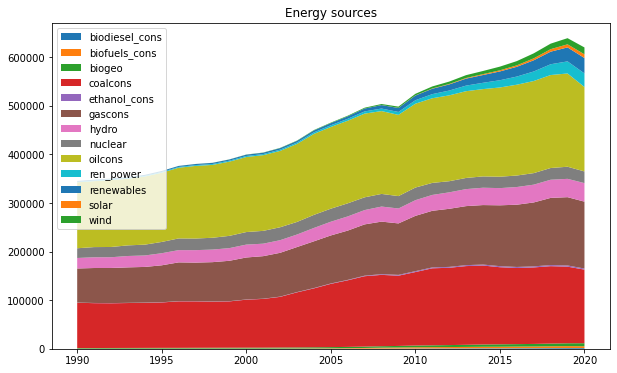

In [30]:
plt.stackplot(data_energy_sectors['Year'],
              data_energy_sectors.drop('Year', axis = 1).to_numpy().transpose(),
              labels = list(data_energy_sectors.drop('Year', axis = 1).columns))
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"]=(16, 10)
plt.title('Energy sources')
plt.show()

## Scatterplots on long-term data

Let's now look at the granular data (country level).  
To do so, we must merge the two datasets.

In [31]:
data_merged = pd.merge(data_energy_sources.replace("US", "United States"),
                       data_ghg, on = ['Year', 'Country'])
data_merged

,Country,Year,Region,Var,Consumption,Sector,Emissions
0,Algeria,1990,Africa,wind,0.000000e+00,Total including LUCF,95.67
1,Algeria,1990,Africa,wind,0.000000e+00,Total excluding LUCF,95.01
2,Algeria,1990,Africa,wind,0.000000e+00,Energy,78.22
...,...,...,...,...,...,...,...
341849,Vietnam,2018,Asia Pacific,biofuels_cons,4.119205e-08,Bunker Fuels,4.30
341850,Vietnam,2018,Asia Pacific,biofuels_cons,4.119205e-08,Other Fuel Combustion,4.21
341851,Vietnam,2018,Asia Pacific,biofuels_cons,4.119205e-08,Land-Use Change and Forestry,-12.09


In [32]:
data_merged['Country'].unique()

array(['Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan',
       'Bangladesh', 'Belarus', 'Belgium', 'Brazil', 'Bulgaria', 'Canada',
       'Chile', 'China', 'Colombia', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Ecuador', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Kazakhstan', 'Kuwait', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands',
       'New Zealand', 'Norway', 'Oman', 'Pakistan', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Qatar', 'Romania', 'Saudi Arabia',
       'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea',
       'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Thailand',
       'Turkey', 'Turkmenistan', 'United States', 'Ukraine',
       'United Arab Emirates', 'United Kingdom', 'Uzbekistan',
       'Venezuela', 'Vietnam'], dtype=object)

We can now look at correlations.

(0.008, 100000)

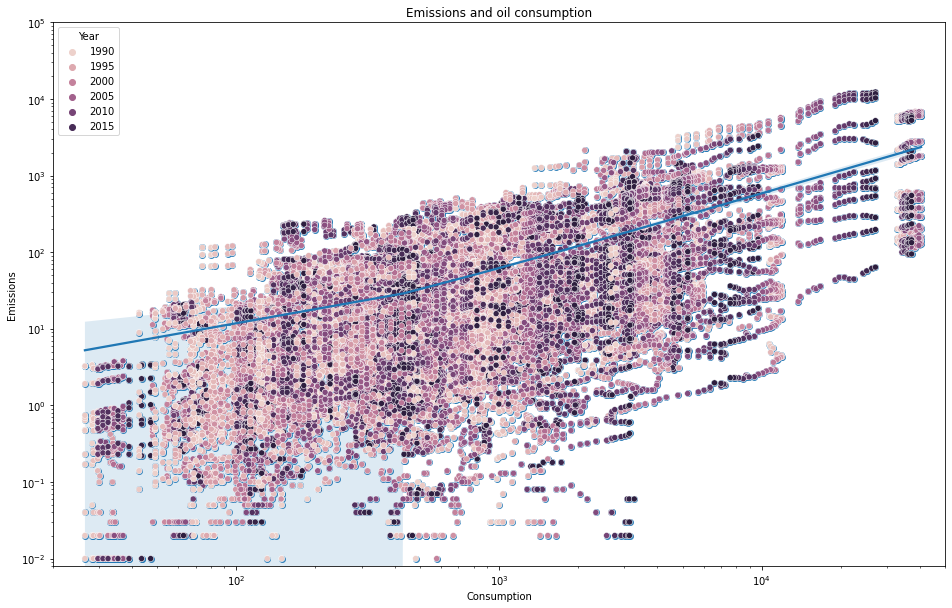

In [33]:
sns.regplot(data = data_merged.query('Var == "oilcons"'), 
            x = "Consumption", 
            y = "Emissions")
sns.scatterplot(data = data_merged.query('Var == "oilcons"'), 
                x = 'Consumption', 
                y = 'Emissions',
                hue = 'Year')
plt.xscale('log')
plt.yscale('log')
plt.title('Emissions and oil consumption')
plt.xlim(20,50000)
plt.ylim(0.008,10**5)

Each point represents one country and one year.  
Let's have a look at what happens for wind, but with a focus on regions/continent this time.




Text(0.5, 1.0, 'Emissions and renewable energy consumption')

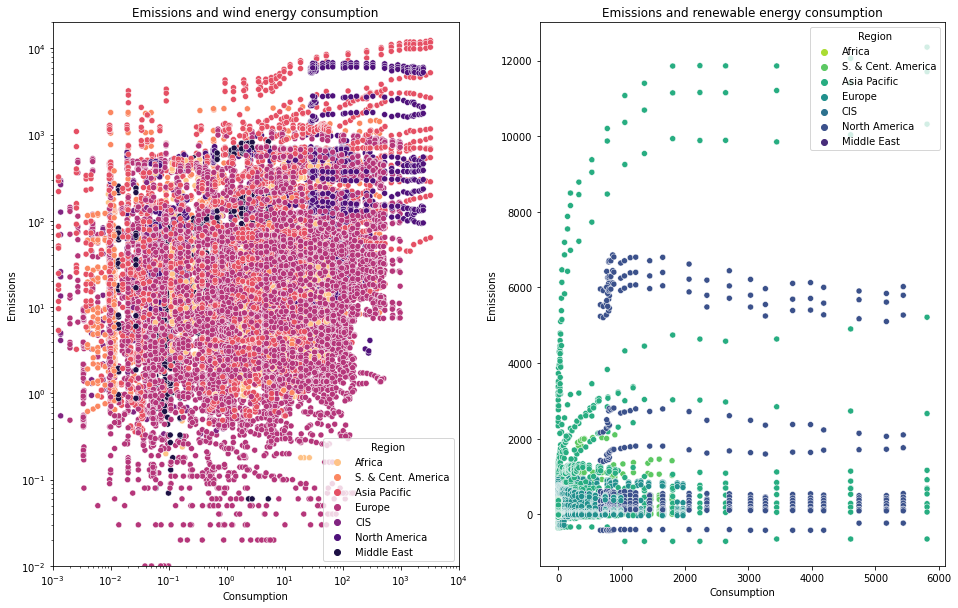

In [34]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(ax = ax[0],
                data = data_merged.query('Var == "wind"'), 
                x = "Consumption", 
                y = "Emissions",
                hue = "Region",
                palette = 'magma_r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Emissions and wind energy consumption')
ax[0].set_xlim(0.001,10**4)
ax[0].set_ylim(0.01,20000)

sns.scatterplot(ax = ax[1],
                data = data_merged.query('Var == "renewables"'), 
                x = "Consumption", 
                y = "Emissions",
                hue = "Region",
                palette = 'viridis_r')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_title('Emissions and renewable energy consumption')
#ax[1].set_xlim(10**8,10**14)
#ax[1].set_ylim(1,10**5)

Things are less straightforward here.... 
Let's have a look at aggregate values for countries.


Text(0.5, 1.0, 'Emissions and renewable energy consumption')

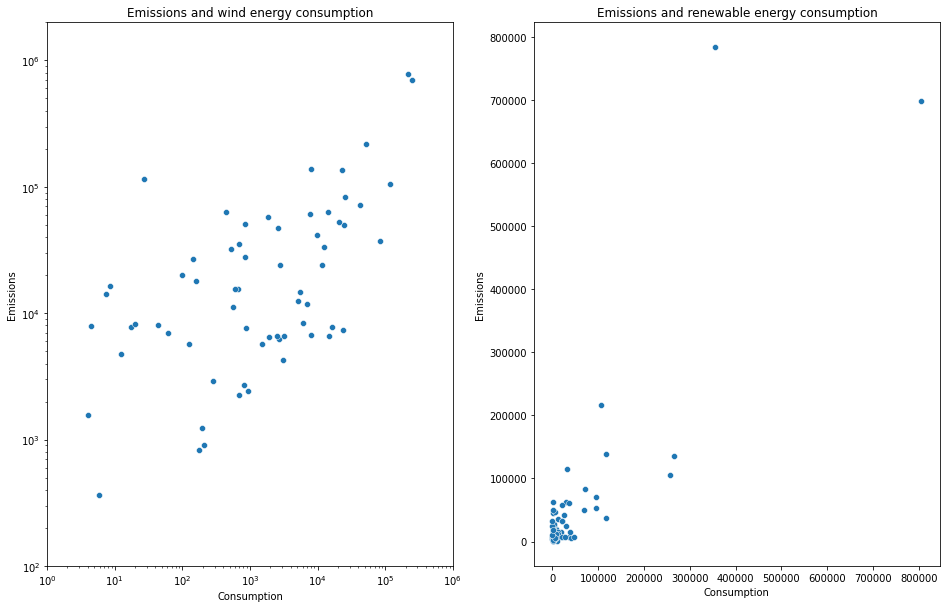

In [35]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(ax = ax[0],
                data = data_merged.query('Var == "wind"').pivot_table(values=['Consumption', 'Emissions'],  # This creates the pivot table
                                       aggfunc='sum', 
                                       index=['Country']), 
                x = "Consumption", 
                y = "Emissions")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Emissions and wind energy consumption')
ax[0].set_xlim(1,10**6)
ax[0].set_ylim(100,2000000)

sns.scatterplot(ax = ax[1],
                data = data_merged.query('Var == "renewables"').pivot_table(values=['Consumption', 'Emissions'],  # This creates the pivot table
                                       aggfunc='sum', 
                                       index=['Country']), 
                x = "Consumption", 
                y = "Emissions")
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_title('Emissions and renewable energy consumption')
#ax[1].set_xlim(10**8,10**14)
#ax[1].set_ylim(1,10**5)

Here, both variables seem somewhat correlated. 
There are size effects: naturally, the US & China dominate for both criteria.  
We would need to look at *relative* values to see a different picture.

## Conclusion

Aggregate energy consumption is deeply linked with (and *probably* causes) emissions.   
For some energy types (e.g., wind), the link is less clear.   
The issue is that such types are marginal in the global mix of energy consumption, which is dominated by oil, coal and gas.  